In [ ]:
import yfinance as yf
import math
import numpy as np
import pandas as pd
import datetime
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM
from keras.layers import Dropout

In [68]:
nvda_hist = pd.read_csv("/content/nvda_historical_data.csv")
nvda_hist.head()

,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits
0,2000-01-03 00:00:00-05:00,0.090268,0.090984,0.084297,0.089431,300912000,0.0,0.0
1,2000-01-04 00:00:00-05:00,0.087879,0.088118,0.082625,0.087044,300480000,0.0,0.0
2,2000-01-05 00:00:00-05:00,0.084536,0.085969,0.082984,0.084178,188352000,0.0,0.0
3,2000-01-06 00:00:00-05:00,0.084178,0.084178,0.075462,0.078685,120480000,0.0,0.0
4,2000-01-07 00:00:00-05:00,0.078327,0.080835,0.077134,0.079999,71184000,0.0,0.0


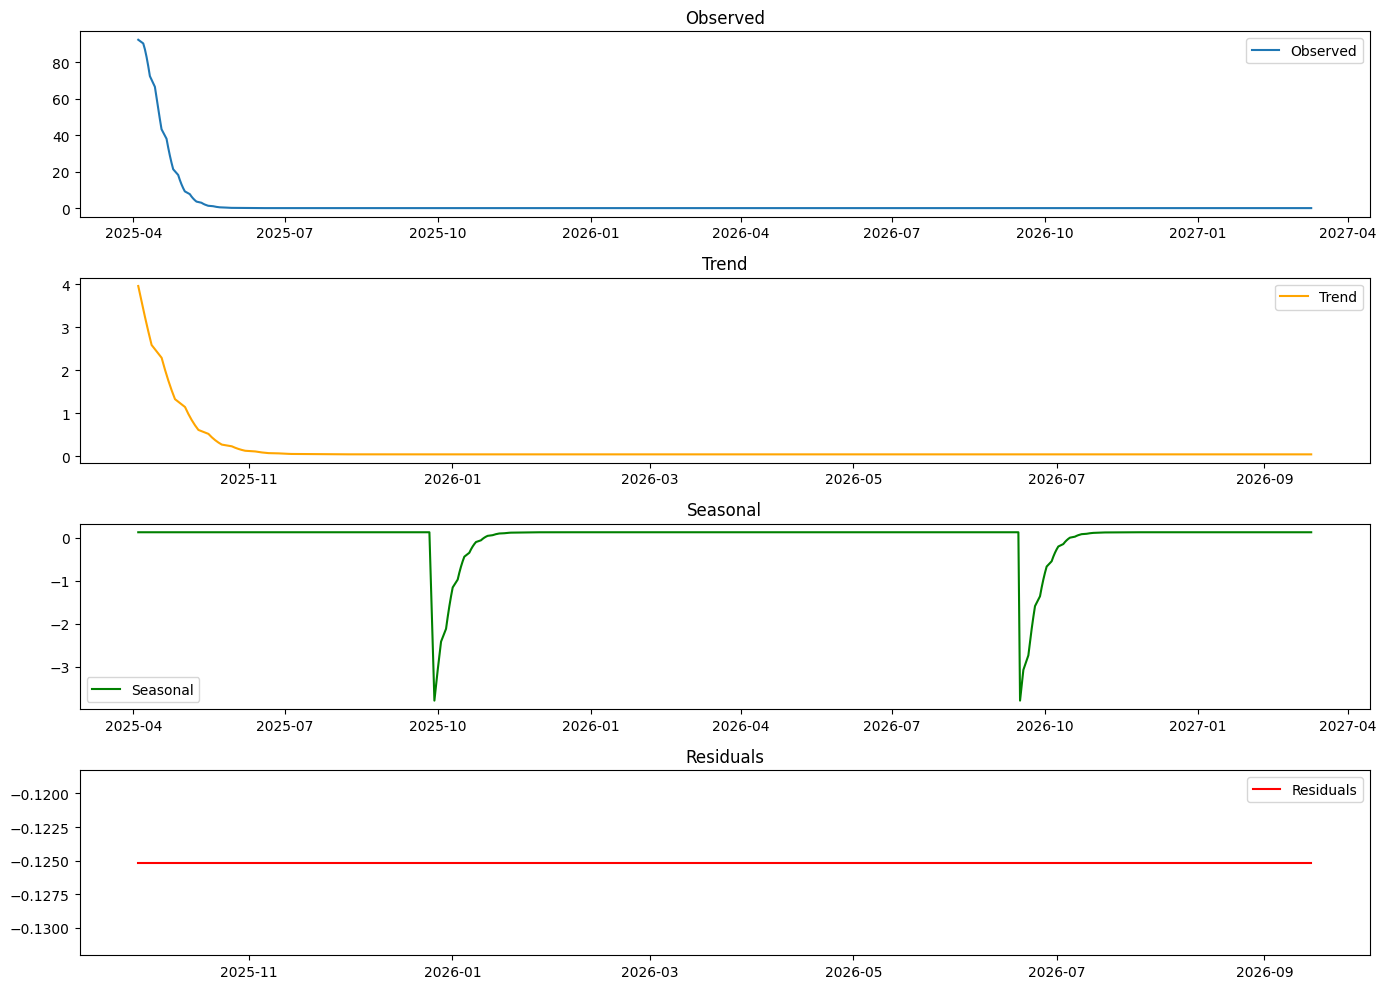

In [ ]:
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.filters.hp_filter import hpfilter
import statsmodels.api as sm

predicted_prices = pd.Series(future_predictions.flatten(), index=future_dates)
decomposition = seasonal_decompose(predicted_prices, model='additive', period=252)

plt.figure(figsize=(14,10))

plt.subplot(4,1,1)
plt.plot(decomposition.observed, label = "Observed")
plt.title("Observed")
plt.legend()

plt.subplot(4,1,2)
plt.plot(decomposition.trend, label = "Trend", color="orange")
plt.title("Trend")
plt.legend()

plt.subplot(4,1,3)
plt.plot(decomposition.seasonal, label = "Seasonal", color="green")
plt.title("Seasonal")
plt.legend()

plt.subplot(4,1,4)
plt.plot(decomposition.resid, label = "Residuals", color="red")
plt.title("Residuals")
plt.legend()

plt.tight_layout()
plt.show()

Epoch 1/5


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


197/197 ━━━━━━━━━━━━━━━━━━━━ 63s 288ms/step - loss: 0.0022 - mae: 0.0179
Epoch 2/5
197/197 ━━━━━━━━━━━━━━━━━━━━ 58s 296ms/step - loss: 3.3376e-04 - mae: 0.0088
Epoch 3/5
197/197 ━━━━━━━━━━━━━━━━━━━━ 58s 296ms/step - loss: 3.5484e-04 - mae: 0.0081
Epoch 4/5
197/197 ━━━━━━━━━━━━━━━━━━━━ 82s 298ms/step - loss: 4.2573e-04 - mae: 0.0096
Epoch 5/5
197/197 ━━━━━━━━━━━━━━━━━━━━ 82s 298ms/step - loss: 2.5288e-04 - mae: 0.0075


<ipython-input-70-44d7df83a630>:52: FutureWarning: In a future version of pandas, parsing datetimes with mixed time zones will raise an error unless `utc=True`. Please specify `utc=True` to opt in to the new behaviour and silence this warning. To create a `Series` with mixed offsets and `object` dtype, please use `apply` and `datetime.datetime.strptime`
  nvda_hist["Date"] = pd.to_datetime(nvda_hist["Date"])


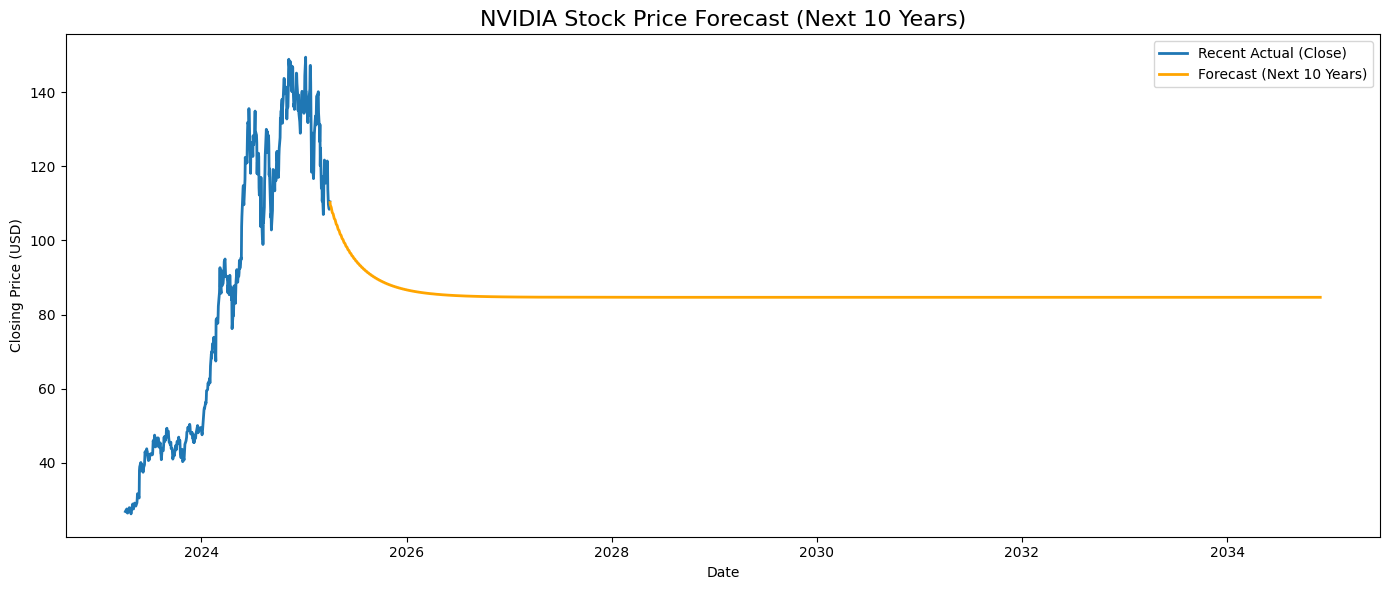

In [70]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from statsmodels.tsa.seasonal import seasonal_decompose

# === STEP 1: Preprocessing & Scaling ===
sequence_length = 60  # Use 60 days of past data for predictions
data = nvda_hist["Close"].values.reshape(-1, 1)

# Scale data to [0, 1]
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(data)

# Create sequences
sequences = []
target = []
for i in range(len(scaled_data) - sequence_length):
    sequences.append(scaled_data[i:i + sequence_length])
    target.append(scaled_data[i + sequence_length])

X = np.array(sequences)
y = np.array(target)

# === STEP 2: Train LSTM model on entire historical data ===
model = Sequential()
model.add(LSTM(128, input_shape=(sequence_length, 1), return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(128, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(128))
model.add(Dense(1, activation='linear'))

model.compile(optimizer='adam', loss='mse', metrics=['mae'])
model.fit(X, y, epochs=5, batch_size=32)

# === STEP 3: Forecast 10 Years (2520 business days) ===
future_predictions = []
last_sequence = scaled_data[-sequence_length:]

for _ in range(2520):  # 10 years of business days
    input_seq = last_sequence.reshape(1, sequence_length, 1)
    next_scaled = model.predict(input_seq, verbose=0)[0][0]
    future_predictions.append(next_scaled)
    last_sequence = np.append(last_sequence[1:], next_scaled)

# Inverse transform predictions to real prices
future_predictions = scaler.inverse_transform(np.array(future_predictions).reshape(-1, 1)).flatten()

nvda_hist["Date"] = pd.to_datetime(nvda_hist["Date"])

nvda_hist.set_index("Date", inplace=True)

# === STEP 4: Generate future date range and create DataFrame ===
last_date = nvda_hist.index[-1]
future_dates = pd.bdate_range(start=last_date + pd.Timedelta(days=1), periods=2520)

future_df = pd.DataFrame({
    "Date": future_dates,
    "Predicted_Close": future_predictions.flatten()
}).set_index("Date")

# === STEP 5: Plot the results ===
plt.figure(figsize=(14, 6))
plt.plot(nvda_hist.index[-500:], nvda_hist["Close"].values[-500:], label='Recent Actual (Close)', linewidth=2)
plt.plot(future_df.index, future_df["Predicted_Close"], label='Forecast (Next 10 Years)', color='orange', linewidth=2)
plt.title("NVIDIA Stock Price Forecast (Next 10 Years)", fontsize=16)
plt.xlabel("Date")
plt.ylabel("Closing Price (USD)")
plt.legend()
plt.tight_layout()
plt.show()

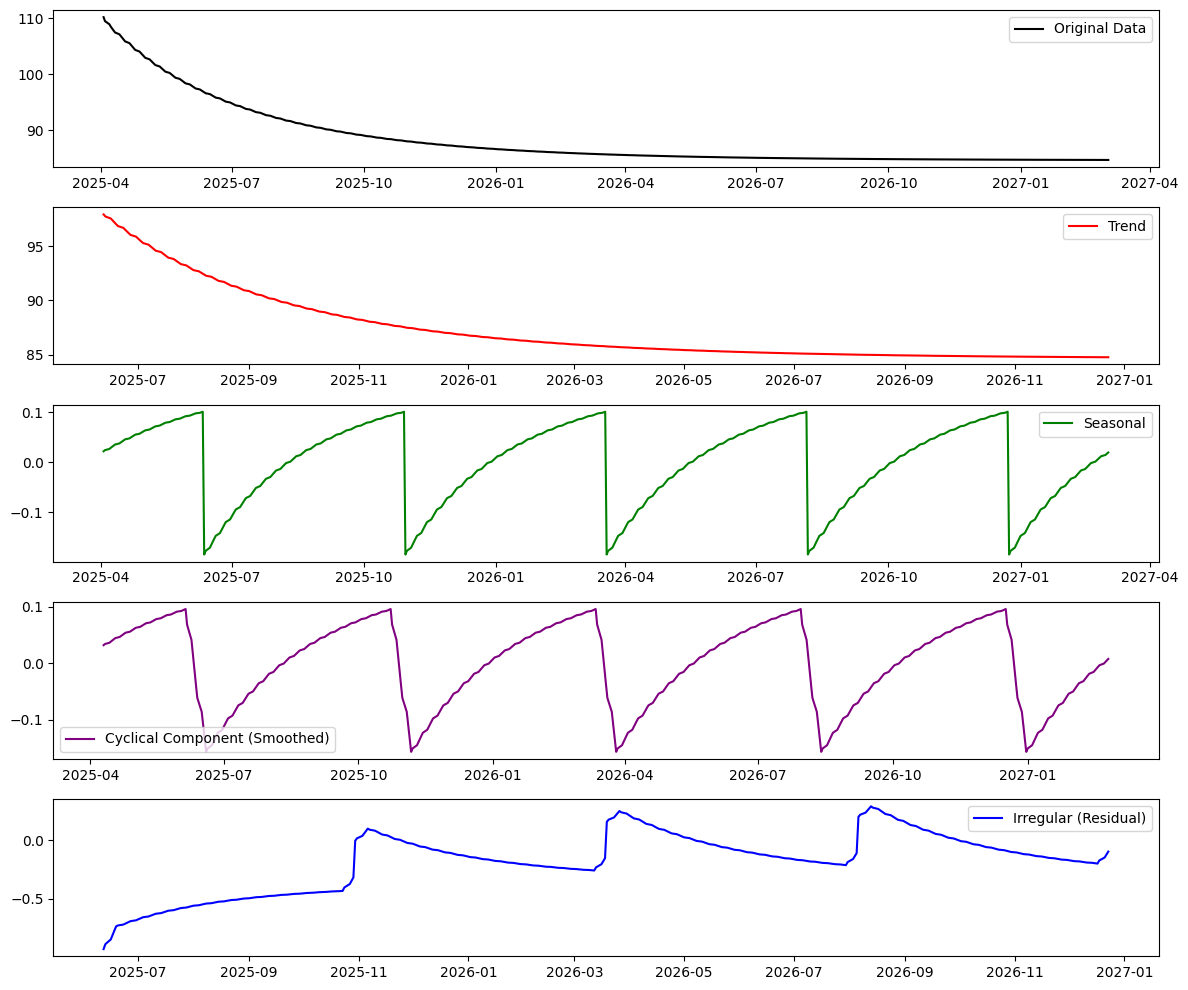

In [71]:
# === STEP 6: Decompose time series for first ~2 years ===
predicted_subset = future_df["Predicted_Close"].iloc[:500]  # ~2 years of business days

# Decompose with a shorter seasonal period (~quarterly)
decomposition = seasonal_decompose(predicted_subset, model='additive', period=100)

# Extract components
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid
cyclical = seasonal.rolling(window=10, center=True).mean()
irregular = residual - cyclical

# Plot decomposition
plt.figure(figsize=(12, 10))
plt.subplot(511)
plt.plot(predicted_subset, color='black', label='Original Data')
plt.legend(loc='best')

plt.subplot(512)
plt.plot(trend, color='red', label='Trend')
plt.legend(loc='best')

plt.subplot(513)
plt.plot(seasonal, color='green', label='Seasonal')
plt.legend(loc='best')

plt.subplot(514)
plt.plot(cyclical, color='purple', label='Cyclical Component (Smoothed)')
plt.legend(loc='best')

plt.subplot(515)
plt.plot(irregular, color='blue', label='Irregular (Residual)')
plt.legend(loc='best')

plt.tight_layout()
plt.show()
